http://www.asasrms.org/Proceedings/y2023/files/HB_JSM_2023.pdf

https://ssc.ca/sites/default/files/survey/documents/SSC2003_R_Belcher.pdf



# Background

The HB-edit method was proposed by Hidroglou and Berthelot (1986) to improve on editting survey data conducted by Statistics Canada. Detecting outliers in survey data can be difficult due to the extreme variation in the size of respondents.

To demonstrate this method I am going to use the 2020 and 2010 Census tract-level population estimates. Code to create this dataset from the Census API is available here:

```python
import requests
import pandas as pd
from tqdm import tqdm

state_fips = [f"{i:02d}" for i in range(1, 57) if i not in {3, 7, 14, 43, 52}]

def fetch_tracts(year, var, base):
    """
    Fetch tract-level totals for all states for a given year.
    year: 2010 or 2020 (only used for clarity)
    var:  'P001001' (2010) or 'P1_001N' (2020)
    base: 'https://api.census.gov/data/2010/dec/sf1' or 'https://api.census.gov/data/2020/dec/pl'
    """
    frames = []
    states = [f"{i:02d}" for i in range(1, 57) if i not in {3, 7, 14, 43, 52}]

    for st in tqdm(states, desc=f"Downloading {year} tracts"):
        # Example:
        # .../data/2020/dec/pl?get=NAME,P1_001N&for=tract:*&in=state:01&in=county:*
        url = f"{base}?get=NAME,{var}&for=tract:*&in=state:{st}&in=county:*"
        response = requests.get(url, timeout=120)
        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame(data[1:], columns=data[0])
        # Ensure numeric population
        df[var] = pd.to_numeric(df[var], errors="coerce")
        frames.append(df)

    if not frames:
        return pd.DataFrame(columns=["NAME", var, "state", "county", "tract"])

    out = pd.concat(frames, ignore_index=True)
    return out

# -------- fetch --------
# 2010 Decennial SF1, total population P001001
df10_raw = fetch_tracts(
    year=2010,
    var="P001001",
    base="https://api.census.gov/data/2010/dec/sf1"
)

# 2020 PL 94-171, total population P1_001N
df20_raw = fetch_tracts(
    year=2020,
    var="P1_001N",
    base="https://api.census.gov/data/2020/dec/pl"
)

# -------- tidy + merge --------
df10 = df10_raw.rename(columns={"P001001": "POP_2010"})
df20 = df20_raw.rename(columns={"P1_001N": "POP_2020"})

# Keep consistent keys
keep_cols = ["NAME", "state", "county", "tract"]
df10 = df10[keep_cols + ["POP_2010"]]
df20 = df20[keep_cols + ["POP_2020"]]

# Merge on tract FIPS (state+county+tract) and NAME
tracts = df10.merge(df20, on=["state", "county", "tract", "NAME"], how="outer")

# Optional: build a full 11-digit tract GEOID (2 state + 3 county + 6 tract)
tracts["GEOID"] = tracts["state"].str.zfill(2) + tracts["county"].str.zfill(3) + tracts["tract"].str.zfill(6)

# Reorder columns nicely
tracts = tracts[["GEOID", "NAME", "state", "county", "tract", "POP_2010", "POP_2020"]]
```

In [84]:
import pandas as pd
df = pd.read_csv("census_tract_population_2010_2020.csv").dropna()
df = df[(df["POP_2010"] > 0) & (df["POP_2020"] > 0)]
df

,GEOID,NAME,state,county,tract,POP_2010,POP_2020
0,1001020100,"Census Tract 201, Autauga County, Alabama",1,1,20100,1912.0,1775.0
1,1001020200,"Census Tract 202, Autauga County, Alabama",1,1,20200,2170.0,2055.0
2,1001020300,"Census Tract 203, Autauga County, Alabama",1,1,20300,3373.0,3216.0
3,1001020400,"Census Tract 204, Autauga County, Alabama",1,1,20400,4386.0,4246.0
8,1001020600,"Census Tract 206, Autauga County, Alabama",1,1,20600,3668.0,3729.0
...,...,...,...,...,...,...,...
96906,72153750501,"Census Tract 7505.01, Yauco Municipio, Puerto ...",72,153,750501,4960.0,3968.0
96907,72153750502,"Census Tract 7505.02, Yauco Municipio, Puerto ...",72,153,750502,2092.0,1845.0
96908,72153750503,"Census Tract 7505.03, Yauco Municipio, Puerto ...",72,153,750503,2357.0,2155.0
96909,72153750601,"Census Tract 7506.01, Yauco Municipio, Puerto ...",72,153,750601,5315.0,4368.0


Create vector of ratios, $r_k$, by dividing the current estimates by the prior:

$$r_k = \frac{y_k}{x_k}; k=1,2,\cdots,n$$

where $n$ is the number of observation units.


To detect outleirs in both tails the HB method applies a centering transformation to produce non-negative and symmetric transformed ratios, $s_k$:
$$
s_k =
\begin{cases}
1 - \dfrac{r_{Q_2}}{r_k}, & \text{if } 0 < r_k < r_{Q_2} \\
\dfrac{r_k}{r_{Q_2}} - 1, & \text{otherwise}
\end{cases}
$$

where $r_{Q_2}$ is the median of $r_k$.

Then, to account for the size of the observation the HB method creates an effector vector, $e_k$, by scaling the symmetric ratios as followis:

$$
e_k = s_k \max(x_k, y_k)^u, \text{ where } 0 \le u \le 1
$$

In [85]:
import numpy as np

def hidiroglou_berthelot_outliers(y_k, x_k, u = 0.5, a = 0.05, c = 4, quantile_lo = 0.25, quantile_hi = 0.75, verbose = False):
    """
    Hidiroglou-Berthelot Method (...) for Outliers.

    Assume numerator and denominator are same length.

    Parameters
    ----------
    y_k : 1D data
        Data to test.
    x_k : 1D data
        Data to test.
    u : float
        Parameter. Controls curve of final boundaries. Commonly (u = 0.50)
    a : float
        Parameter. Ensures upper and ower bounds are not arbitrarily close to the median. (a = 0.05)
    c : float
        Parameter. Controls the width of the acceptance region. (c = 4)
    quantlie_lo : float
        Parameter. Optional quantile for lower bound of effects vector. Usually 25th percentile, but could be 10th.
    quantlie_lo : float
        Parameter. Optional quantile for lower bound of effects vector. Usually 75th percentile, but could be 90th.

    Returns
    -------
    outliers : ndarray of bool, shape (n,)
        Boolean mask indicating which points in `data` are considered outliers. 
        True for detected outliers, False otherwise (including NaNs).

    References
    ----------
    Hidiroglou, M.A., and Berthelot, J.-M. (1986). ”Statistical Editing and Imputation for Periodic Business Surveys”. Survey Methodology, 12, 73-83.
    """
    y_k = np.array(y_k)
    x_k = np.array(x_k)

    # Check length
    if y_k.shape[0] != x_k.shape[0]:
        raise ValueError(f"y_k and x_k must be the same length. Got lengths: {len(y_k)} and {len(x_k)}")

    # Ignore NaNs and zeros
    valid = (x_k != 0) & (y_k != 0) & ~np.isnan(x_k) & ~np.isnan(y_k)

    # Ratio
    r_k = y_k[valid] / x_k[valid]

    # Ratio Median
    r_Q2 = np.quantile(r_k, 0.50)

    # Centering transformation
    s_k = np.where(
        (r_k < r_Q2) & (r_k > 0),
        1 - (r_Q2 / r_k), # 0 < r_k < r_Q2
        (r_k / r_Q2) - 1  # Otherwise
    )

    # Effects vector
    e_k = s_k * np.maximum(x_k[valid], y_k[valid])**u
    
    e_Q1 = np.quantile(e_k, quantile_lo) 
    e_Q2 = np.quantile(e_k, 0.50) 
    e_Q3 = np.quantile(e_k, quantile_hi) 

    # Upper and Lower HB Bounds
    bound_lo = e_Q2 - c * max(e_Q2 - e_Q1, a * np.abs(e_Q2))
    bound_hi = e_Q2 + c * max(e_Q3 - e_Q2, a * np.abs(e_Q2))

    # Masks effects vectors as outliers
    outlier_effects = (e_k < bound_lo) | (e_k > bound_hi)

    # Creates mask like original length of data
    outliers = np.full_like(x_k, False, dtype = bool)
    outliers[valid] = outlier_effects
    return outliers

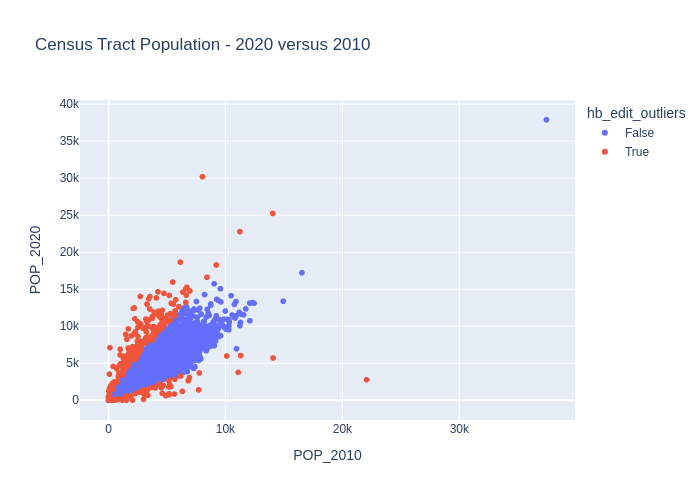

In [90]:
import plotly.express as px
from IPython.display import Image, display
df["hb_edit_outliers"] = hidiroglou_berthelot_outliers(
    df["POP_2020"],
    df["POP_2010"],
    u = 0.5, a = 0.05, c = 10, quantile_lo = 0.1, quantile_hi = 0.9
)
fig = px.scatter(
    df,
    x = "POP_2010",
    y = "POP_2020",
    color = "hb_edit_outliers",
    title = "Census Tract Population - 2020 versus 2010"
)
fig.write_image('fig1.png')
display(Image(filename="fig1.png"))
#fig.show()